# 3D random point cloud

In this example we will see how permaviss works in a torus. 
We start by taking a sample of 1000 points from a 3 dimensional unit cube. Since this sample is too big, we take a subsample of 150 points by using a minmax method. We store it in `point_cloud`.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
import scipy.spatial.distance as dist

from permaviss.sample_point_clouds.examples import random_cube, take_sample

X = random_cube(1000,3)
point_cloud = take_sample(X,150)

Dist = dist.squareform(dist.pdist(point_cloud))

## Vietoris Rips complex

Now, we compute the Vietoris Rips complex of `point_cloud`. But before we need to import some functions from **permaviss**.

In [12]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

We set the parameter `max_dim` for the maximum dimension and  `max_r` for the maximum radius of the Vietoris-Rips complex produced from `point_cloud`.

In [16]:
max_r = 0.32
max_dim = 3


C, R = vietoris_rips(Dist, max_r, max_dim)

## Compute ordinary Persistent Homology

Afterwards, we compute the complex differentials using arithmetic mod `p`, a prime number.
Then we get the persistent homology of `point_cloud` with the specified parameters. We store the result in `PerHom`. 

In [17]:
from permaviss.persistence_algebra.PH_classic import persistent_homology

p = 5

Diff = complex_differentials(C, p)
PerHom, _, _ = persistent_homology(Diff, R, max_r, p)

[[ 0.26349317  0.28141142]
 [ 0.26829181  0.26830006]
 [ 0.27440454  0.30762284]
 [ 0.27491209  0.31095757]
 [ 0.27886104  0.32      ]
 [ 0.28061229  0.29480032]
 [ 0.28324016  0.32      ]
 [ 0.28408279  0.28529067]
 [ 0.28441318  0.30127611]
 [ 0.28954852  0.32      ]
 [ 0.29313546  0.32      ]
 [ 0.29445658  0.30343778]
 [ 0.29716889  0.29923996]
 [ 0.30037373  0.31243215]
 [ 0.30303834  0.31161393]
 [ 0.30462749  0.31857531]
 [ 0.30529789  0.32      ]
 [ 0.30545466  0.32      ]
 [ 0.31203991  0.32      ]
 [ 0.31372436  0.32      ]
 [ 0.31793312  0.32      ]]


## Now, do the same computation using the Mayer-Vietoris spectral sequence

Now we will proceed to compute again persistent homology of `point_cloud` using the Persistence Mayer-Vietoris spectral sequence instead. For this task we take the same parameters `max_r`, `max_dim` and `p` as before. Let us first import **create_MV_ss**. 

In [18]:
from permaviss.spectral_sequence.MV_spectral_seq import create_MV_ss

We set `max_div`, which is the number of divisions along the coordinate with greater range in `point_cloud`, to be 2. This will indicate **create_MV_ss** to cover `point_cloud` by 8 hypercubes. Also, we set the `overlap` between neighbouring regions to be slightly greater than `max_r`. The method **create_MV_ss** prints the ranks of the computed pages and returns a spectral sequence object which we store in `MV_ss`. This will take a couple of minutes.

In [19]:
max_div = 2
overlap = max_r*1.01

MV_ss = create_MV_ss(point_cloud, max_r, max_dim, max_div, overlap, p)

PAGE: 1
[[ 20   0   0   0   0   0   0   0   0]
 [163  72  24   6   0   0   0   0   0]
 [325 351 376 374 280 140  40   5   0]]
PAGE: 2
[[ 20   0   0   0   0   0   0   0   0]
 [110   1   0   0   0   0   0   0   0]
 [151   5   1   0   0   0   0   0   0]]
PAGE: 3
[[ 20   0   0   0   0   0   0   0   0]
 [109   1   0   0   0   0   0   0   0]
 [151   5   0   0   0   0   0   0   0]]
PAGE: 4
[[ 20   0   0   0   0   0   0   0   0]
 [109   1   0   0   0   0   0   0   0]
 [151   5   0   0   0   0   0   0   0]]


Now, we compare the computed persistent homology barcodes by both methods. Unless an `AssertError` comes up, this means that the computed barcodes **coincide**. Also, we plot the relevant barcodes. 

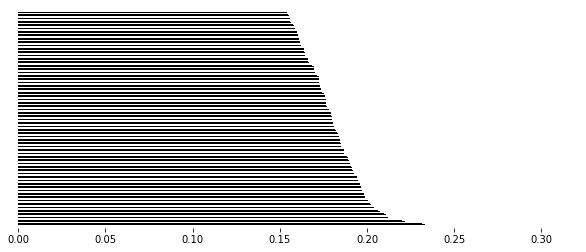

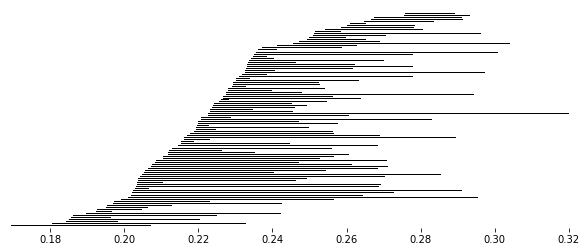

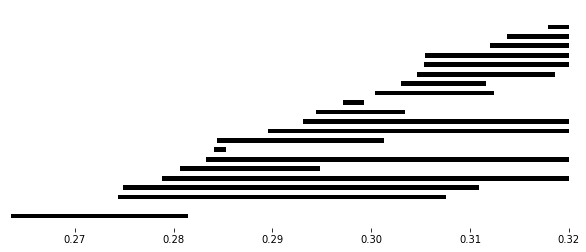

In [21]:
for it, PH in enumerate(MV_ss.persistent_homology):
    # print(PH.barcode)
    min_r = min(PH.barcode[0,:])
    assert np.array_equal(PH.barcode, PerHom[it].barcode)
    step = max_r/PH.dim
    width = step / 2.
    fig, ax = plt.subplots(figsize = (10,4))
    ax = plt.axes(frameon=False)
    y_coord = 0
    # Plot barcodes
    for k, b in enumerate(PH.barcode):
        ax.fill([b[0],b[1],b[1],b[0]],[y_coord,y_coord,y_coord+width,y_coord+width],'black',label='H0')
        y_coord += step
  

    # Show figure 
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim([min_r,max_r])
    ax.set_ylim([-step, max_r + step])
    plt.savefig("barcode_r{}.png".format(it))
    plt.show()

## Extended bars

Here we look at the extension information on one dimensional persistence classes. For this we exploit the extra information stored in `MV_ss`. What we do is plot the one dimensional barcodes, highlighting those bars from the ``(0,1)`` position in the infinity page in red. Also, we highlight in blue when these bars are extended by a bar in the ``(1,0)`` position on the infinity page. All the black bars are only comming from classes in the ``(1,0)`` position on the infinity page.  

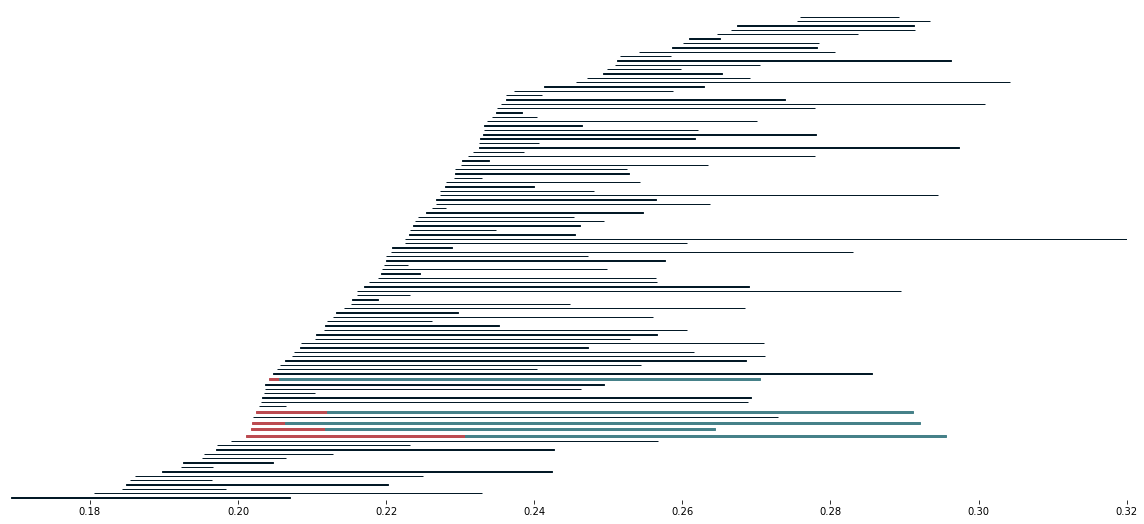

In [23]:
PH = MV_ss.persistent_homology
start_rad = min(PH[1].barcode[:,0])
end_rad = max(PH[1].barcode[:,1])
persistence = end_rad - start_rad
fig, ax = plt.subplots(figsize = (20,9))
ax = plt.axes(frameon=False)
# ax = plt.axes()
step = (persistence /2) / PH[1].dim
width = (step/6.)
y_coord = 0
for b in PH[1].barcode:
    if b[0] not in MV_ss.Hom[2][1][0].barcode[:,0]:
        ax.fill([b[0],b[1],b[1],b[0]],[y_coord,y_coord,y_coord+width,y_coord+width],c="#031926", edgecolor='none')
    else:
        index = np.argmax(b[0] <= MV_ss.Hom[2][1][0].barcode[:,0])
        midpoint = MV_ss.Hom[2][1][0].barcode[index,1]
        ax.fill([b[0], midpoint, midpoint, b[0]],[y_coord,y_coord,y_coord+step,y_coord+step],c="#bc4b51", edgecolor='none')
        ax.fill([midpoint, b[1], b[1], midpoint],[y_coord,y_coord,y_coord+step,y_coord+step],c='#468189', edgecolor='none')
        y_coord = y_coord + step

    y_coord += 2 * step 

# Show figure
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim([start_rad,end_rad])
ax.set_ylim([-step, y_coord + step])
plt.show()